# Hybrid Stock Market Prediction using Numerical and Textual Analysis


---


## The Sparks Foundation GRIP Program


---


## **Description:**

This project aims to develop a hybrid model to predict the performance of the SENSEX (S&P BSE SENSEX) using both numerical analysis of historical stock prices and sentiment analysis of news headlines.

## **Objectives:**

1. Analyze historical SENSEX data to identify trends and patterns
2. Perform sentiment analysis on Times of India news headlines
3. Combine these inputs to create a hybrid prediction model
4. Evaluate the model's performance and make predictions

## **Author:** Aziz Sayadi



# Data Collection

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob
import yfinance as yf

# Fetch SENSEX data
sensex = yf.Ticker("^BSESN")
historical_data = sensex.history(period="5y")

# Load news headlines data (assuming it's already downloaded)
news_data = pd.read_csv("/content/india-news-headlines.csv")

# Display first few rows of each dataset
print(historical_data.head())
print(news_data.head())

                                   Open          High           Low  \
Date                                                                  
2019-07-12 00:00:00+05:30  38941.101562  39021.839844  38684.851562   
2019-07-15 00:00:00+05:30  39009.949219  39023.968750  38696.601562   
2019-07-16 00:00:00+05:30  38961.859375  39173.890625  38845.269531   
2019-07-17 00:00:00+05:30  39171.101562  39284.730469  39081.140625   
2019-07-18 00:00:00+05:30  39204.468750  39204.468750  38861.250000   

                                  Close  Volume  Dividends  Stock Splits  
Date                                                                      
2019-07-12 00:00:00+05:30  38736.230469   12900        0.0           0.0  
2019-07-15 00:00:00+05:30  38896.710938   18000        0.0           0.0  
2019-07-16 00:00:00+05:30  39131.039062   25100        0.0           0.0  
2019-07-17 00:00:00+05:30  39215.640625   23400        0.0           0.0  
2019-07-18 00:00:00+05:30  38897.460938   24100     

# Data Preprocessing

In [31]:
# Preprocess historical data
historical_data = historical_data.reset_index()
historical_data['Date'] = pd.to_datetime(historical_data['Date'], utc=True)
historical_data = historical_data.sort_values('Date')

# Preprocess news data
news_data['publish_date'] = pd.to_datetime(news_data['publish_date'], utc=True)
news_data = news_data.sort_values('publish_date')

In [32]:
# Merge datasets on date
merged_data = pd.merge_asof(historical_data, news_data, left_on='Date', right_on='publish_date')

# Handle missing values
merged_data = merged_data.dropna()

print(merged_data.head())


                       Date          Open          High           Low  \
0 2019-07-11 18:30:00+00:00  38941.101562  39021.839844  38684.851562   
1 2019-07-14 18:30:00+00:00  39009.949219  39023.968750  38696.601562   
2 2019-07-15 18:30:00+00:00  38961.859375  39173.890625  38845.269531   
3 2019-07-16 18:30:00+00:00  39171.101562  39284.730469  39081.140625   
4 2019-07-17 18:30:00+00:00  39204.468750  39204.468750  38861.250000   

          Close  Volume  Dividends  Stock Splits  \
0  38736.230469   12900        0.0           0.0   
1  38896.710938   18000        0.0           0.0   
2  39131.039062   25100        0.0           0.0   
3  39215.640625   23400        0.0           0.0   
4  38897.460938   24100        0.0           0.0   

                         publish_date headline_category  \
0 1970-01-01 00:00:00.020220331+00:00        city.salem   
1 1970-01-01 00:00:00.020220331+00:00        city.salem   
2 1970-01-01 00:00:00.020220331+00:00        city.salem   
3 1970-01-01

# Numerical Analysis of Historical Stock Prices

In [33]:
# Prepare data for LSTM
def prepare_data(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [34]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data[['Close']])

In [35]:
# Split the data
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [36]:
# Prepare datasets for LSTM
look_back = 60
X_train, y_train = prepare_data(train, look_back)
X_test, y_test = prepare_data(test, look_back)

In [37]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [38]:
# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [39]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
29/29 [==============================] - 8s 76ms/step - loss: 0.0419
Epoch 2/100
29/29 [==============================] - 3s 98ms/step - loss: 0.0051
Epoch 3/100
29/29 [==============================] - 4s 132ms/step - loss: 0.0038
Epoch 4/100
29/29 [==============================] - 2s 82ms/step - loss: 0.0038
Epoch 5/100
29/29 [==============================] - 2s 76ms/step - loss: 0.0034
Epoch 6/100
29/29 [==============================] - 2s 76ms/step - loss: 0.0030
Epoch 7/100
29/29 [==============================] - 2s 76ms/step - loss: 0.0028
Epoch 8/100
29/29 [==============================] - 3s 94ms/step - loss: 0.0030
Epoch 9/100
29/29 [==============================] - 4s 130ms/step - loss: 0.0034
Epoch 10/100
29/29 [==============================] - 3s 94ms/step - loss: 0.0026
Epoch 11/100
29/29 [==============================] - 3s 93ms/step - loss: 0.0027
Epoch 12/100
29/29 [==============================] - 3s 109ms/step - loss: 0.0028
Epoch 13/100
29/29 [==

In [40]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

6/6 [==============================] - 0s 23ms/step


In [41]:
# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [42]:
# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 13574.924910030935
Test RMSE: 5493.094394954465


# Sentiment Analysis of News Headlines

In [43]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

merged_data['sentiment'] = merged_data['headline_text'].apply(get_sentiment)

In [45]:
# Calculate daily average sentiment
daily_sentiment = merged_data.groupby('Date')['sentiment'].mean().reset_index()
merged_data = pd.merge(merged_data, daily_sentiment, on='Date', suffixes=('', '_avg'))

print(merged_data.head())

                       Date          Open          High           Low  \
0 2019-07-11 18:30:00+00:00  38941.101562  39021.839844  38684.851562   
1 2019-07-14 18:30:00+00:00  39009.949219  39023.968750  38696.601562   
2 2019-07-15 18:30:00+00:00  38961.859375  39173.890625  38845.269531   
3 2019-07-16 18:30:00+00:00  39171.101562  39284.730469  39081.140625   
4 2019-07-17 18:30:00+00:00  39204.468750  39204.468750  38861.250000   

          Close  Volume  Dividends  Stock Splits  \
0  38736.230469   12900        0.0           0.0   
1  38896.710938   18000        0.0           0.0   
2  39131.039062   25100        0.0           0.0   
3  39215.640625   23400        0.0           0.0   
4  38897.460938   24100        0.0           0.0   

                         publish_date headline_category  \
0 1970-01-01 00:00:00.020220331+00:00        city.salem   
1 1970-01-01 00:00:00.020220331+00:00        city.salem   
2 1970-01-01 00:00:00.020220331+00:00        city.salem   
3 1970-01-01

# Hybrid Model Development

In [46]:
# Prepare data for hybrid model
look_back = 60
X, y = [], []

for i in range(len(merged_data) - look_back):
    X.append(np.column_stack((
        merged_data['Close'].values[i:(i + look_back)],
        merged_data['sentiment_avg'].values[i:(i + look_back)]
    )))
    y.append(merged_data['Close'].values[i + look_back])

X, y = np.array(X), np.array(y)


In [47]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
# Normalize the data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [49]:
X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))


In [50]:
# Create and fit the hybrid LSTM model
hybrid_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])


In [51]:
hybrid_model.compile(optimizer='adam', loss='mean_squared_error')

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [52]:
# Train the model
history = hybrid_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
24/24 [==============================] - 12s 256ms/step - loss: 0.0509 - val_loss: 0.0055
Epoch 2/200
24/24 [==============================] - 2s 91ms/step - loss: 0.0072 - val_loss: 0.0019
Epoch 3/200
24/24 [==============================] - 2s 91ms/step - loss: 0.0037 - val_loss: 9.5608e-04
Epoch 4/200
24/24 [==============================] - 2s 99ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 5/200
24/24 [==============================] - 2s 92ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 6/200
24/24 [==============================] - 3s 145ms/step - loss: 0.0035 - val_loss: 8.5882e-04
Epoch 7/200
24/24 [==============================] - 3s 144ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 8/200
24/24 [==============================] - 2s 91ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 9/200
24/24 [==============================] - 2s 90ms/step - loss: 0.0032 - val_loss: 8.2961e-04
Epoch 10/200
24/24 [==============================] - 2s 92ms/step - loss: 0.0031 - 

# Model Evaluation

In [53]:
# Make predictions
train_predict = hybrid_model.predict(X_train)
test_predict = hybrid_model.predict(X_test)

8/8 [==============================] - 0s 26ms/step


In [54]:
# Invert predictions
train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

In [55]:
# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))

print(f'Hybrid Model Train RMSE: {train_rmse}')
print(f'Hybrid Model Test RMSE: {test_rmse}')

Hybrid Model Train RMSE: 1133.4207961614609
Hybrid Model Test RMSE: 1119.2936757662349


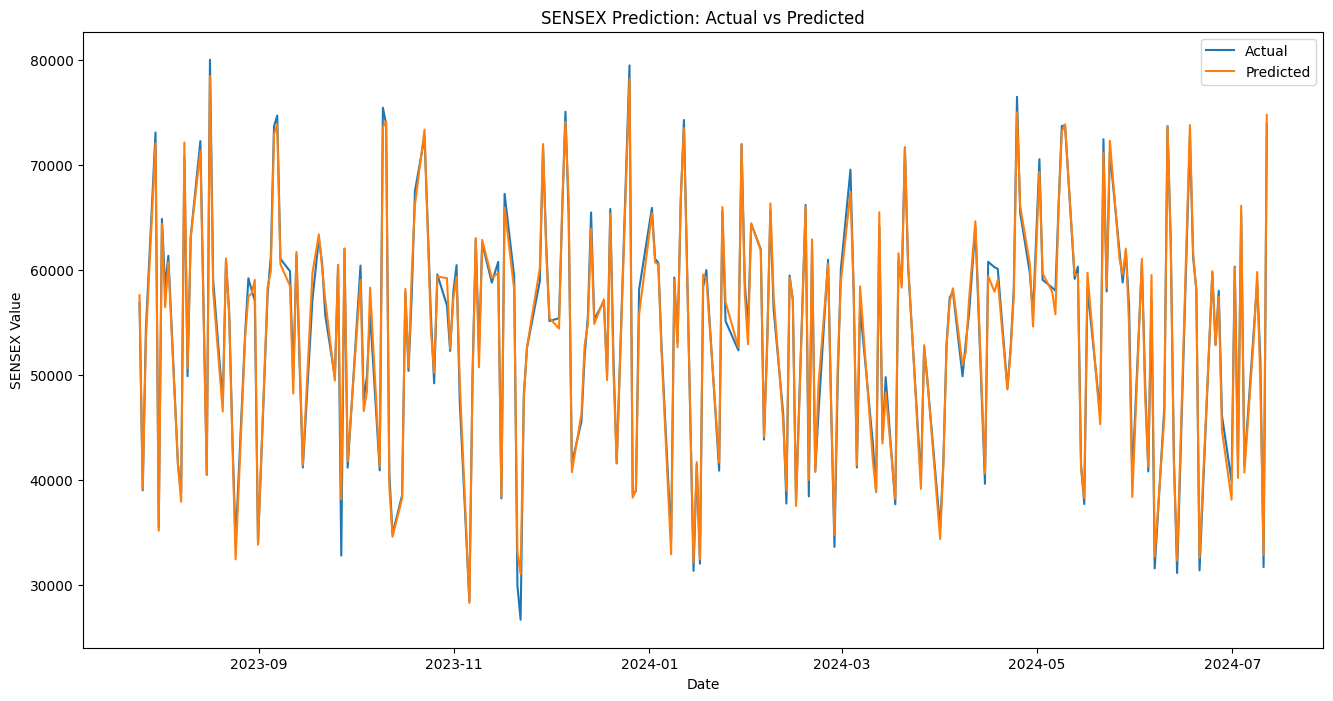

In [56]:
# Visualize predictions
plt.figure(figsize=(16,8))
plt.plot(merged_data['Date'].values[-len(y_test):], y_test, label='Actual')
plt.plot(merged_data['Date'].values[-len(y_test):], test_predict, label='Predicted')
plt.title('SENSEX Prediction: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('SENSEX Value')
plt.legend()
plt.show()

# Prediction and Insights

In [58]:
def make_future_predictions(model, last_known_data, scaler_X, scaler_y, days=30):
    predictions = []
    current_data = last_known_data.copy()

    for _ in range(days):
        # Reshape the data to 3D for the LSTM model
        scaled_data = scaler_X.transform(current_data.reshape(-1, 2)).reshape(1, 60, 2)
        next_day = model.predict(scaled_data)
        predictions.append(scaler_y.inverse_transform(next_day)[0, 0])

        # Update the current_data for the next iteration
        current_data = np.roll(current_data, -1, axis=0)
        current_data[-1] = [next_day[0, 0], current_data[-1, 1]]

    return predictions

# Use the function
last_60_days = merged_data[['Close', 'sentiment_avg']].tail(60).values
future_predictions = make_future_predictions(hybrid_model,
                                             last_60_days, scaler_X, scaler_y)




1/1 [==============================] - 0s 55ms/step


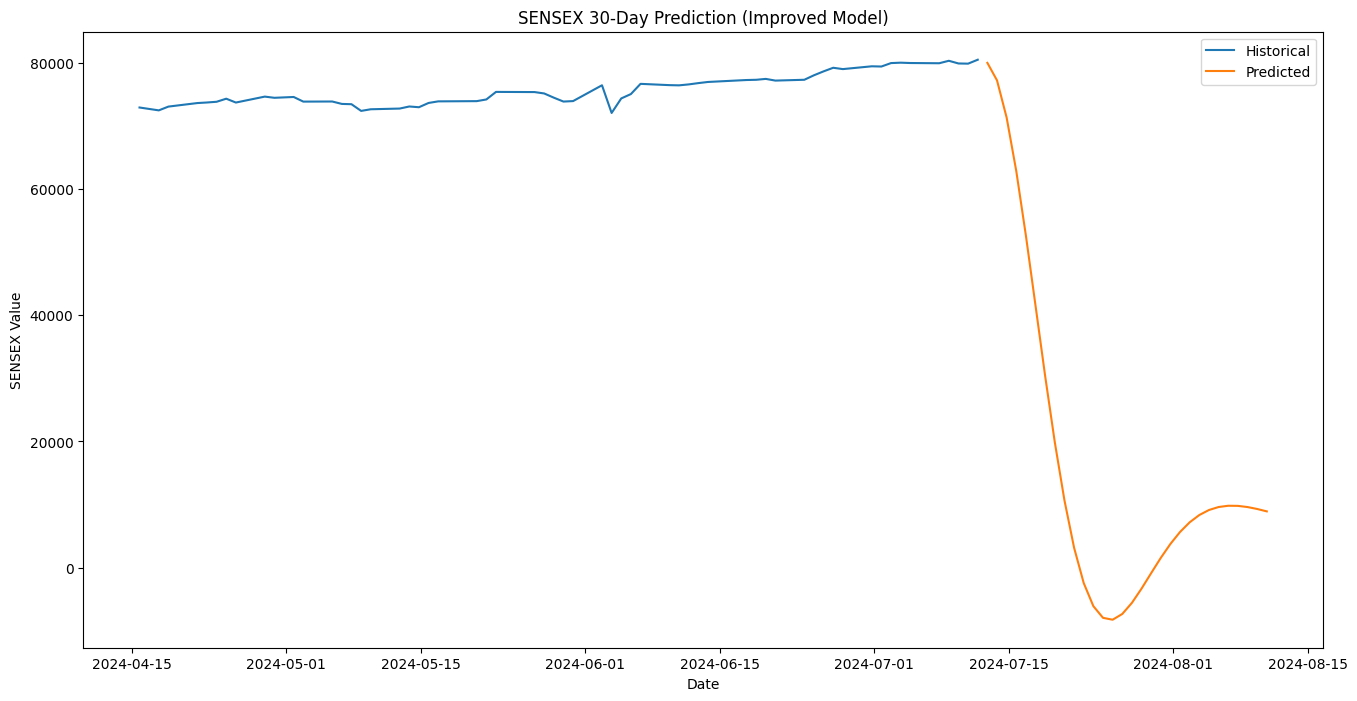

In [59]:
# Plot predictions
future_dates = pd.date_range(start=merged_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(16,8))
plt.plot(merged_data['Date'].tail(60), merged_data['Close'].tail(60), label='Historical')
plt.plot(future_dates, future_predictions, label='Predicted')
plt.title('SENSEX 30-Day Prediction (Improved Model)')
plt.xlabel('Date')
plt.ylabel('SENSEX Value')
plt.legend()
plt.show()


In [60]:
print("Predicted SENSEX values for the next 30 days (Improved Model):")
for date, prediction in zip(future_dates, future_predictions):
    print(f"{date.date()}: {prediction:.2f}")

Predicted SENSEX values for the next 30 days (Improved Model):
2024-07-12: 80021.61
2024-07-13: 77242.50
2024-07-14: 71339.05
2024-07-15: 62854.25
2024-07-16: 52611.43
2024-07-17: 41491.16
2024-07-18: 30328.59
2024-07-19: 19855.09
2024-07-20: 10657.24
2024-07-21: 3146.99
2024-07-22: -2454.36
2024-07-23: -6113.76
2024-07-24: -7964.16
2024-07-25: -8265.13
2024-07-26: -7353.69
2024-07-27: -5593.99
2024-07-28: -3334.10
2024-07-29: -875.32
2024-07-30: 1544.71
2024-07-31: 3756.40
2024-08-01: 5653.68
2024-08-02: 7184.06
2024-08-03: 8336.70
2024-08-04: 9130.45
2024-08-05: 9603.40
2024-08-06: 9804.18
2024-08-07: 9785.45
2024-08-08: 9599.21
2024-08-09: 9293.54
2024-08-10: 8910.82
